In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-sys-1-1-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

In [18]:

def modeling(shift):
    
    ' ----- read data ----- '
    
    chi2_red_new_cut = 0.8

    with tables.open_file(data_dir+'data_full_h5/data_full.h5','r') as f:
        CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
        CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
        CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
        CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
        CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22

        CUT_antistoch = (np.log10(f.root.Collection.cols.chi2_red_new[:]) < chi2_red_new_cut)

        CUT =  CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_antistoch

        zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
        # modify truncated to approximate TRUE muon energy
        truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
        len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
        closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
        d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:][CUT]
        d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:][CUT]
        Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]

        passed_2 = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool)[CUT] # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
        passed_3 = (f.root.IT_veto_double.cols.flag_window_3[:]).astype(bool)[CUT]
        passed_4 = (f.root.IT_veto_double.cols.flag_window_4[:]).astype(bool)[CUT]
        passed_5 = (f.root.IT_veto_double.cols.flag_window_5[:]).astype(bool)[CUT]
    
    ' *** use 2 pulse threshold ***'
    passed_n = passed_2
    Npulse = 2
    
    ' ----- 1. find best exponent p ----- '

    dist_bins = np.linspace(0,2500,100)
#     energy_bins = np.arange(5.5,6.2,0.1) 
    energy_bins = np.arange(5.5,6.2,0.1)
    
    expos = []
    devs = []
    for expo in np.arange(4,8,0.1):
        chisqr_n = [] # goodness of fit
        for b in range(0,len(energy_bins)-1): # in each energy range [E1,E2]
            # energy cut 
            CUT_energy_bin = (np.log10(truncated_muon_e_data_burn)>energy_bins[b])&(np.log10(truncated_muon_e_data_burn)<energy_bins[b+1])
            d_to_IT_center_binned = d_to_IT_center_data_burn[CUT_energy_bin]
            passed_n_binned = passed_n[CUT_energy_bin] # events that pass the veto (not rejected)

            h_total,dist_n = np.histogram(d_to_IT_center_binned,bins=dist_bins)
            h_pass,dist_n = np.histogram(d_to_IT_center_binned[passed_n_binned],bins=dist_bins)
            cut = (h_pass>0) & (h_total>0) # remove empty bins / all vetoed bins 
            dist_n = ((dist_n[1:] + dist_n[:-1])/2)[cut]
            ineff_n = (h_pass/h_total)[cut]
            ineff_n_err = (h_pass/h_total * np.sqrt(1/h_pass + 1/h_total))[cut]

            def ineff_model_npulse(x,a,b):
                return a * np.exp(-b/(x/2000)**(expo)) # asymptotic. Exponent depends on N pulse threshold! [4.5 for 2 pulse]

            p_init = [0.8, 0.05]    
            p_bounds = [[0,0],[1,1]]
            popt, pcov = curve_fit(ineff_model_npulse,dist_n,ineff_n,sigma=ineff_n_err,p0=p_init,bounds=p_bounds)
            chisqr_n = np.append( chisqr_n, 1/(len(ineff_n_err)-2)*np.sum( ((ineff_model_npulse(dist_n,*popt) - ineff_n)/ineff_n_err)**2 ))

        dev = np.sum((chisqr_n - 1)**2) # find total deviation from chisqr=1

        expos = np.append(expos, expo)
        devs = np.append(devs, dev)
    best_expo = expos[devs == np.min(devs)][0]
#     plt.plot(expos,devs,'o-')
#     plt.yscale('log')
    print('best exponent = ',str(best_expo))
    
    ' ----- 2. start fitting as a function of distance -----'
    # store params for each energy bin 
    energy_coord = []
    param_passed_n_a = [] 
    param_passed_n_a_err = []
    param_passed_n_b = [] 
    param_passed_n_b_err = []
    chisqr_n = [] # goodness of fit

    for b in range(0,len(energy_bins)-1): # in each energy range [e1,e2]

        # energy cut 
        CUT_energy_bin = (np.log10(truncated_muon_e_data_burn)>energy_bins[b])&(np.log10(truncated_muon_e_data_burn)<energy_bins[b+1])
        d_to_IT_center_binned = d_to_IT_center_data_burn[CUT_energy_bin]
        passed_n_binned = passed_n[CUT_energy_bin] # events that pass the veto (not rejected)

        h_total,dist_n = np.histogram(d_to_IT_center_binned,bins=dist_bins)
        h_pass,dist_n = np.histogram(d_to_IT_center_binned[passed_n_binned],bins=dist_bins)
        cut = (h_pass>0) & (h_total>0) # remove empty bins / all vetoed bins 
        dist_n = ((dist_n[1:] + dist_n[:-1])/2)[cut]
        ineff_n = (h_pass/h_total)[cut]
        ineff_n_err = (h_pass/h_total * np.sqrt(1/h_pass + 1/h_total))[cut]

        ##### fitting #####
        def ineff_model_npulse(x,a,b):
            return a * np.exp(-b/(x/2000)**(best_expo)) # asymptotic. Exponent depends on N pulse threshold! [4.5 for 2 pulse]

        p_init = [0.8, 0.05]    
        p_bounds = [[0,0],[1,1]]
        popt, pcov = curve_fit(ineff_model_npulse,dist_n,ineff_n,sigma=ineff_n_err,p0=p_init,bounds=p_bounds)

        # for energy fitting 
        energy_coord = np.append(energy_coord, (energy_bins[b]+energy_bins[b+1])/2)

        param_passed_n_a = np.append(param_passed_n_a,popt[0])
        param_passed_n_a_err = np.append(param_passed_n_a_err,np.sqrt(pcov[0,0]))
        param_passed_n_b = np.append(param_passed_n_b,popt[1])
        param_passed_n_b_err = np.append(param_passed_n_b_err,np.sqrt(pcov[1,1]))

        # compute chi2 goodness of fit for later (reduced chi2)
        chisqr_n = np.append( chisqr_n, 1/(len(ineff_n_err)-2)*np.sum( ((ineff_model_npulse(dist_n,*popt) - ineff_n)/ineff_n_err)**2 ))

        " ----- plot ineff vs. dist ----- "
        '''
        plt.rcParams.update({'font.size': 13})
        plt.figure(figsize=(14,5))

        plt.subplot(121)
        plt.axhline(0,ls='--',color='black',alpha=0.8)
        plt.axhline(1,ls='--',color='black',alpha=0.8)

        plt.errorbar(dist_n,ineff_n,yerr=ineff_n_err,fmt='s',alpha=0.5,label=str(Npulse)+' pulses, '+r'$\chi^2_{fit}=$'+str(np.round(chisqr_n[b],2)),color='steelblue')

        dist_dense = np.arange(0,2500,10)
        plt.plot(dist_dense,ineff_model_npulse(dist_dense,*popt),'--',lw=3,color='darkorange')

        plt.xlabel('distance from track to IT center [m]')
        plt.ylabel('IT Ineff')
        plt.xlim(0,2500)
        plt.ylim(-0.05,1.1)
        plt.title(r'$\log_{10}$E$\in$['+str(np.round(energy_bins[b],2))+', '+str(np.round(energy_bins[b+1],2))+']')
        plt.legend(loc='upper left',prop={'size': 9})

        plt.subplot(122)
        plt.axhline(0,ls='--',color='black',alpha=0.8)
        plt.axhline(1,ls='--',color='black',alpha=0.8)

        plt.errorbar(dist_n,ineff_n,yerr=ineff_n_err,fmt='s',alpha=0.5,label=str(Npulse)+' pulses, '+r'$\chi^2_{fit}=$'+str(np.round(chisqr_n[b],2)),color='steelblue')

        dist_dense = np.arange(0,2500,10)
        plt.plot(dist_dense,ineff_model_npulse(dist_dense,*popt),'--',lw=3,color='darkorange')

        plt.xlabel('distance from track to IT center [m]')
        plt.ylabel('log10 IT Ineff')
        plt.xlim(0,2500)
        plt.ylim(2*1e-4,2)
        plt.title(r'$\log_{10}$E$\in$['+str(np.round(energy_bins[b],2))+', '+str(np.round(energy_bins[b+1],2))+']')
        plt.legend(loc='lower right',prop={'size': 9})
        plt.yscale('log')

        plt.show()
        '''
    '----- 3. plot goodness of fit -----'
    '''
    plt.figure()
    plt.plot(energy_coord,chisqr_n,'o-',color='m')
    plt.xlabel('energy bin')
    plt.ylabel(r'$\chi^2_{red}$')
    plt.title('goodness of fit, '+str(Npulse)+' pulses')
    plt.ylim(0,10)
    plt.show()
    '''
    '----- 4. energy fitting -----' 
    
    def e_func(x,c,d,e): # polynomial
        return c*(x-d)**2 + e
    p_bounds = [[-10,4,0],[10,5.47,20]]

    popt_a, pcov_a = curve_fit(e_func,energy_coord,param_passed_n_a,sigma=param_passed_n_a_err,bounds=p_bounds)
    popt_b, pcov_b = curve_fit(e_func,energy_coord,param_passed_n_b,sigma=param_passed_n_b_err,bounds=p_bounds)

    print(popt_a)
    '''
    plt.figure(figsize=(15,5))

    # param a(c,d,e)
    plt.subplot(121)
    plt.errorbar(energy_coord,param_passed_n_a,yerr=param_passed_n_a_err,fmt='s',alpha=0.5,color='m',label=str(Npulse)+' pulses')
    energy_coord_dense = np.arange(5,8,0.1)
    plt.plot(energy_coord_dense,e_func(energy_coord_dense,*popt_a),'--',color='red')
    plt.xlim(5.5,7)
    plt.ylim(0.,1.1)
    plt.legend()
    plt.xlabel(r'$\log_{10}$ truncated muon energy')
    plt.ylabel('parameter a(E)')

    # param b(c,d,e)
    plt.subplot(122)
    plt.errorbar(energy_coord,param_passed_n_b,yerr=param_passed_n_b_err,fmt='s',alpha=0.5,color='m',label=str(Npulse)+' pulses')
    plt.plot(energy_coord_dense,e_func(energy_coord_dense,*popt_b),'--',color='red')
    plt.xlim(5.5,7)
    plt.ylim(-0.1,0.8)
    plt.legend()
    plt.xlabel(r'$\log_{10}$ truncated muon energy')
    plt.ylabel('parameter b(E)')

    plt.show()
    '''
    " ----- Save IT Ineff Model ----- "

    # f = ineff(dist,A,B,C) where A = e_func(Energy,C,D,E), etc
    def IT_model(dist,E): 
        E = E*(1+shift)
        A = e_func(E,*popt_a)
        B = e_func(E,*popt_b)
        tmp = ineff_model_npulse(dist,A,B)
        tmp[tmp<0] = 0
        return tmp

    # 2d pcolor with contour  

    xt = np.linspace(0.001,2500,100) # dist 
    yt = np.linspace(5.5,7,100)  # E 
    xg,yg = np.meshgrid(xt,yt)
    zg = IT_model(xg,yg)

    # if ineff < 0, change to 0! 
    zg[zg<0] = 0

    ##### data model comparison
    
    dist_bins = np.linspace(0,2500,100)
    energy_bins = np.linspace(5.5,7,100)

    plt.figure(figsize=(20,7))
    plt.subplot(121)
    t = np.arange(0,2500,1)
    lowstat = 5.47+2*np.sqrt(1 - ((t-20)/2210)**2)
    plt.plot(t,lowstat,color='black')
    h_before,x,y=np.histogram2d(d_to_IT_center_data_burn,np.log10(truncated_muon_e_data_burn),bins=[dist_bins,energy_bins],range=([[0,2500],[5.5,7]]))
    h_after,x,y=np.histogram2d(d_to_IT_center_data_burn[passed_n],np.log10(truncated_muon_e_data_burn)[passed_n],bins=[dist_bins,energy_bins],range=([[0,2500],[5.5,7]]))
    ineff = (h_after/h_before).T

    plt.plot(t,lowstat,color='black')
    my_cmap = matplotlib.cm.get_cmap('rainbow')
    my_cmap.set_under('w')
    plt.pcolormesh(x,y,ineff,cmap=my_cmap)
    plt.colorbar()
    CS=plt.contour(ineff,extent=[0,2500,5.5,7],levels=[0.2,0.4,0.6,0.8])
    plt.clabel(CS,inline=1,fmt='%1.1f',fontsize=10)
    plt.clim(0,1)
    plt.xlabel('distance from track to IT center [m]')
    plt.ylabel('log(truncated muon energy)')
    plt.xlim(0,2500)
    plt.ylim(5.5,7)
    plt.title('IT Ineff from data, '+str(Npulse)+' pulses')
    
    plt.subplot(122)
    plt.plot(t,lowstat,color='black')
    plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
    plt.colorbar()
    plt.clim(0,1)
    CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)

    plt.xlabel('distance from track to IT center [m]')
    plt.ylabel('log(truncated muon energy)')
    plt.xlim(0,2500)
    plt.ylim(5.5,7)
    plt.title('IT Inefficiency Model using '+str(Npulse)+' pulses')
    plt.show()

    return IT_model, CS

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply


best exponent =  4.6999999999999975
[-0.88732319  5.37333268  0.79654309]


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:234: RuntimeWarning: invalid value encountered in sqrt


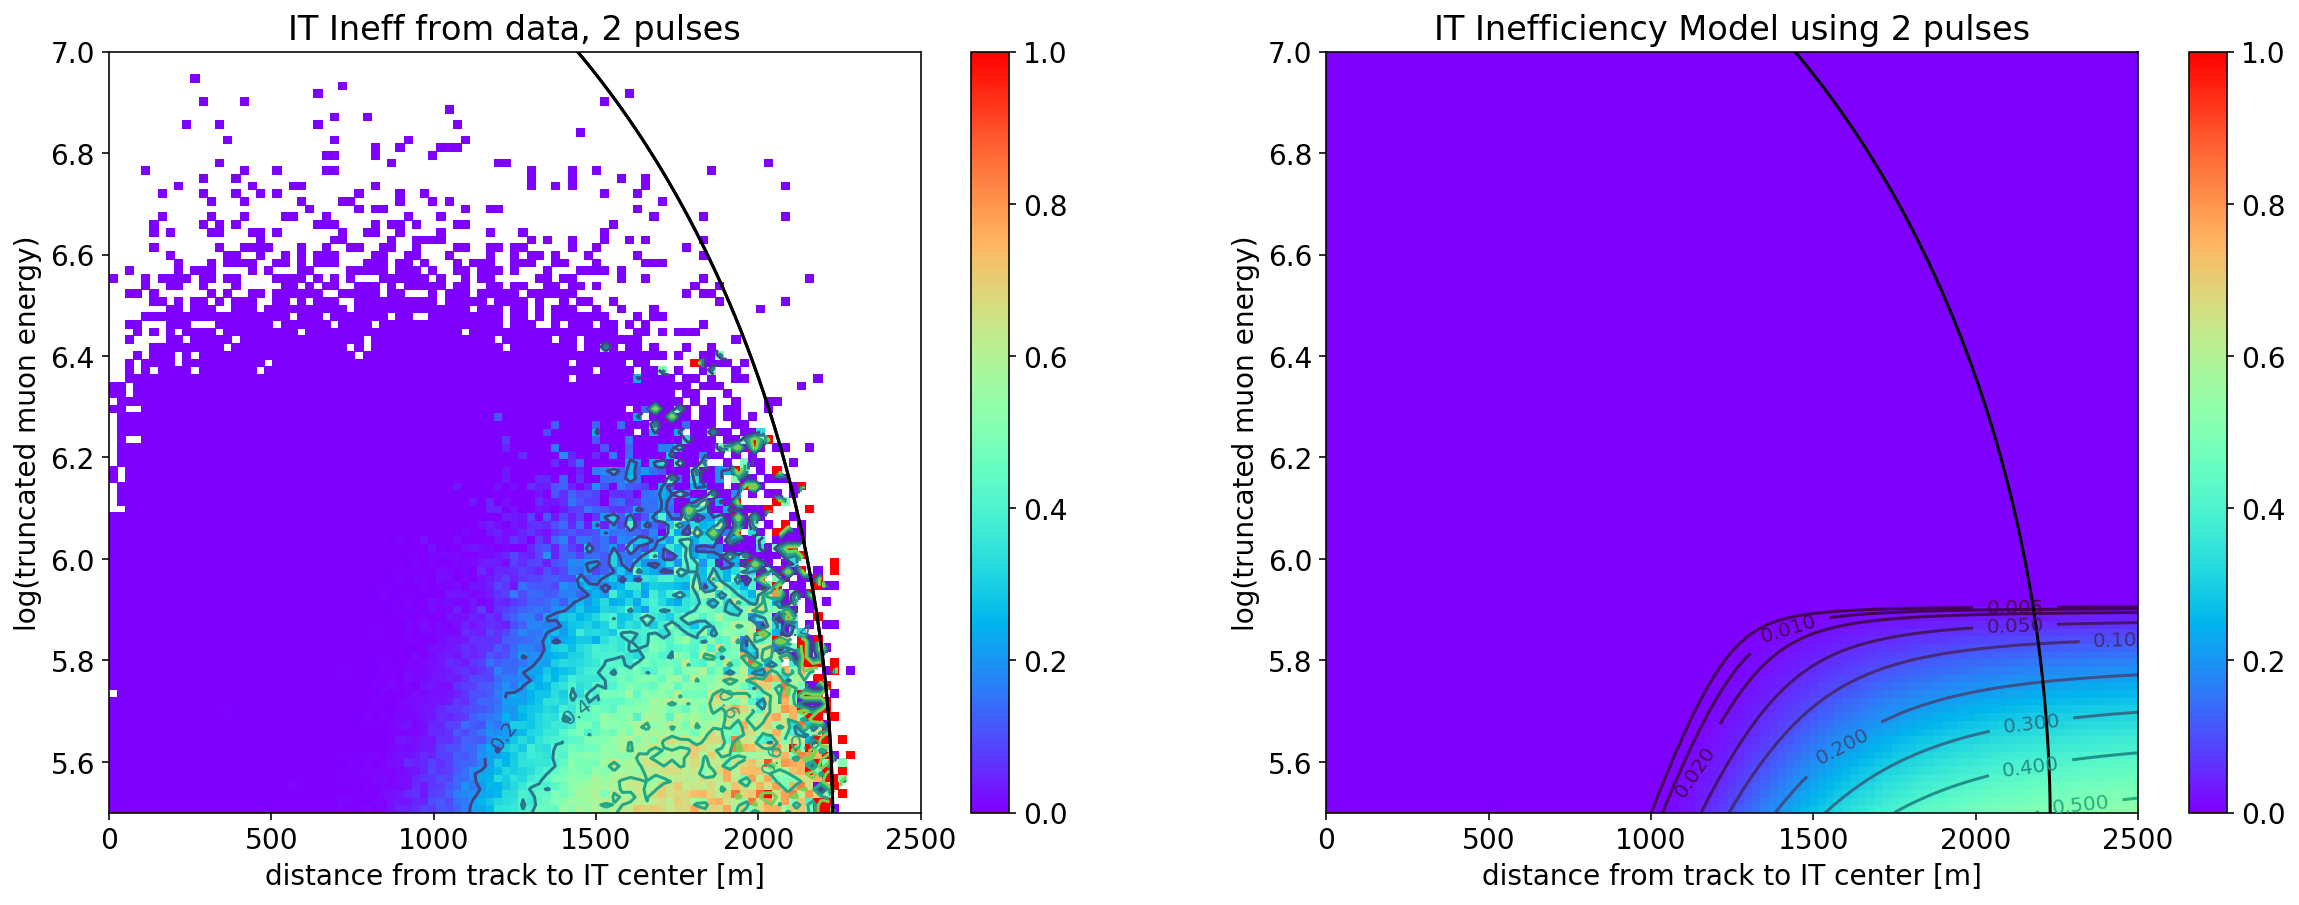

In [23]:
# log10(Etrue) * (1 + shift) = log10(Ereco)
# old contour: f(E) = L
# true contour: f((1+k)*E) = L
    
ineff_07,cs_07 = modeling(0.07)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply


best exponent =  4.6999999999999975
[-0.88732319  5.37333268  0.79654309]


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:234: RuntimeWarning: invalid value encountered in sqrt


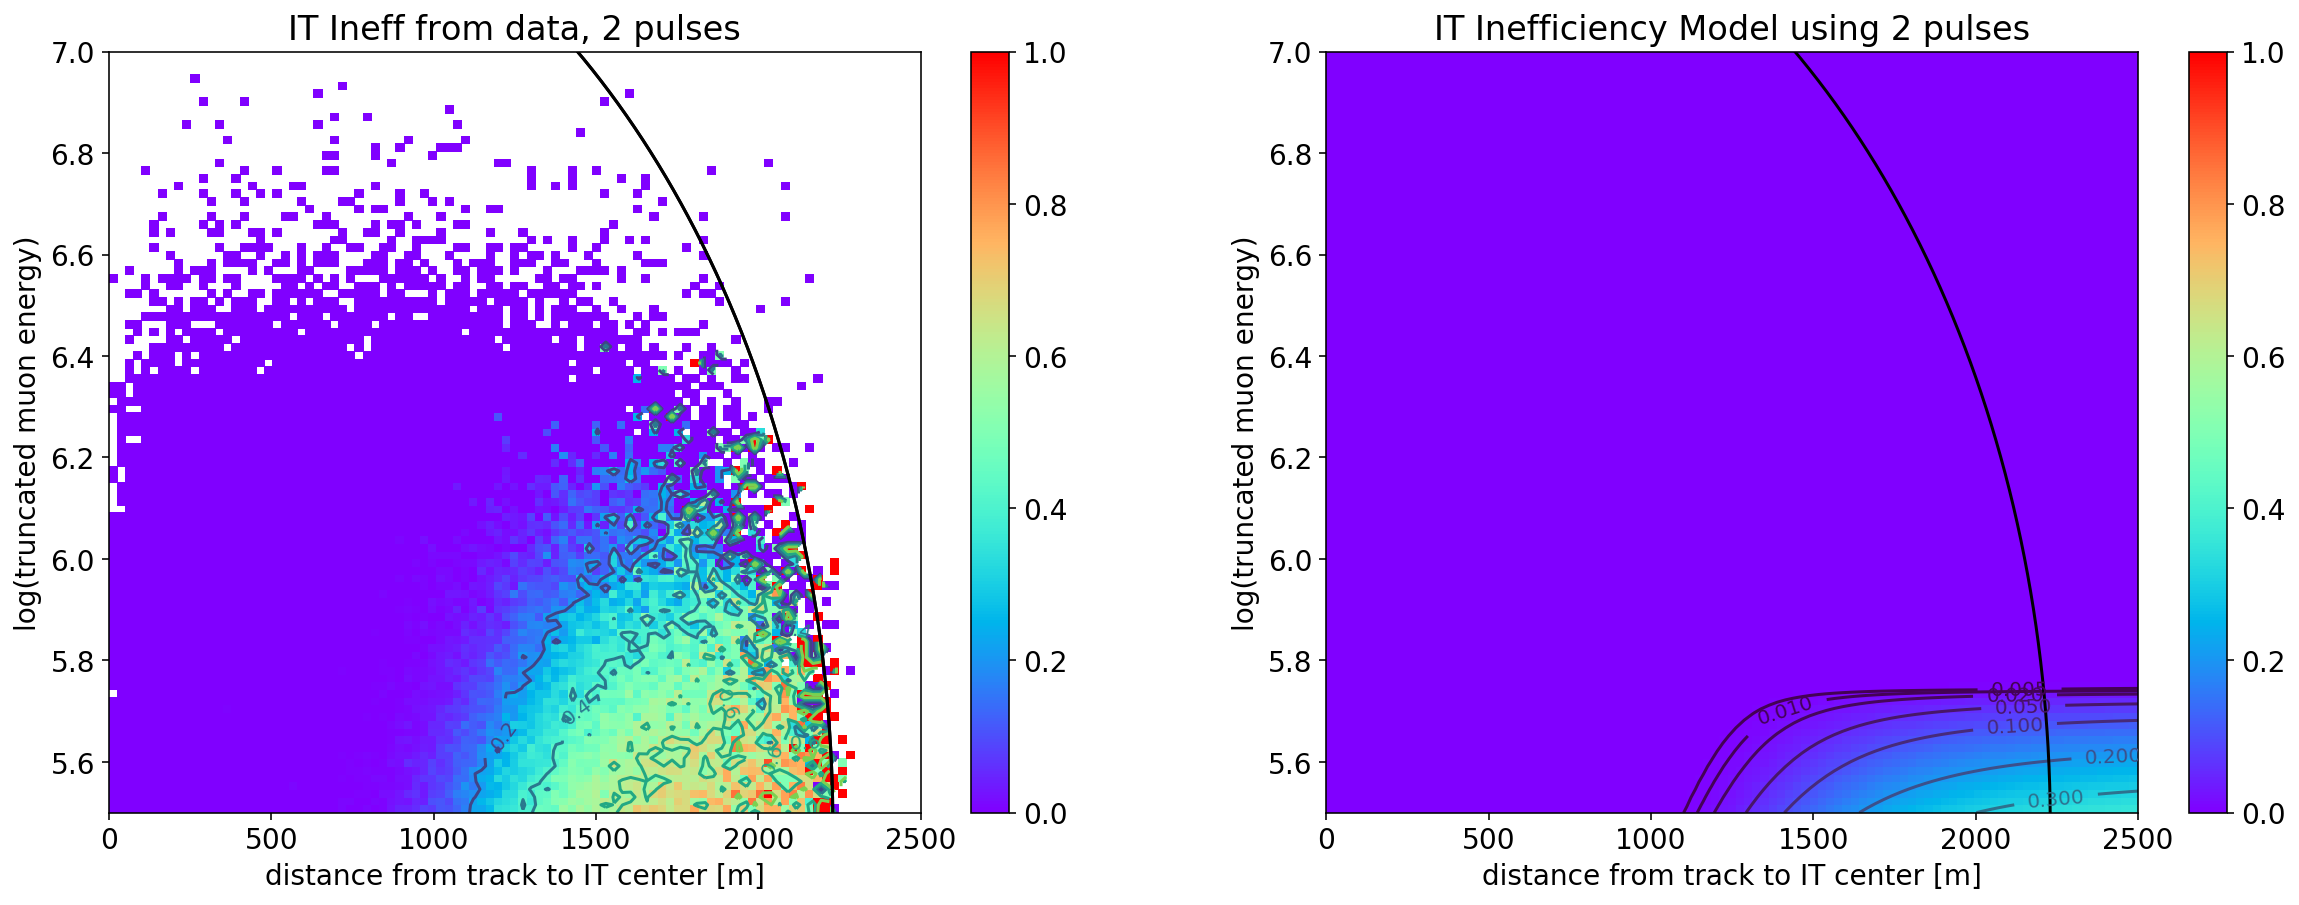

In [20]:
ineff_10,cs_10 = modeling(0.10)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply


best exponent =  4.6999999999999975
[-0.88732319  5.37333268  0.79654309]


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:234: RuntimeWarning: invalid value encountered in sqrt


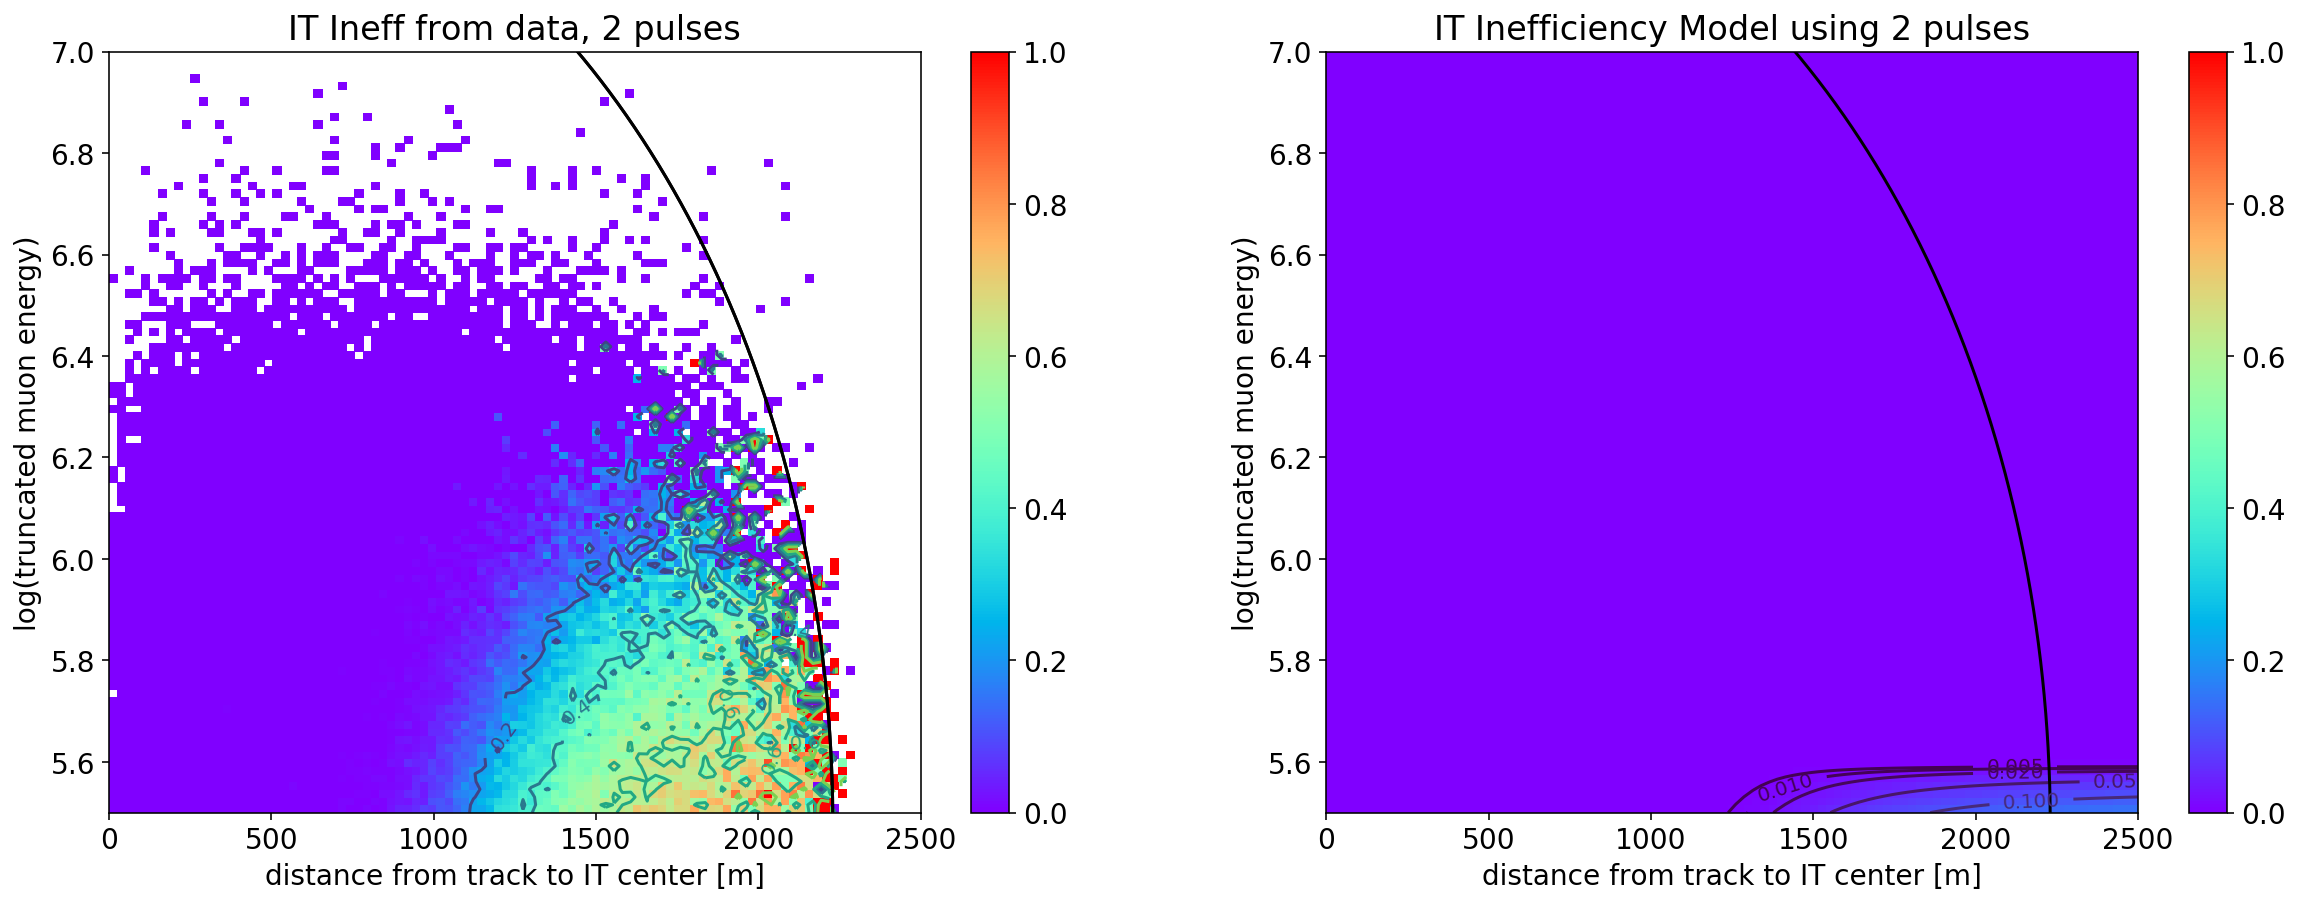

In [21]:
ineff_13,cs_13 = modeling(0.13)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply


best exponent =  4.6999999999999975
[-0.88732319  5.37333268  0.79654309]


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:234: RuntimeWarning: invalid value encountered in sqrt


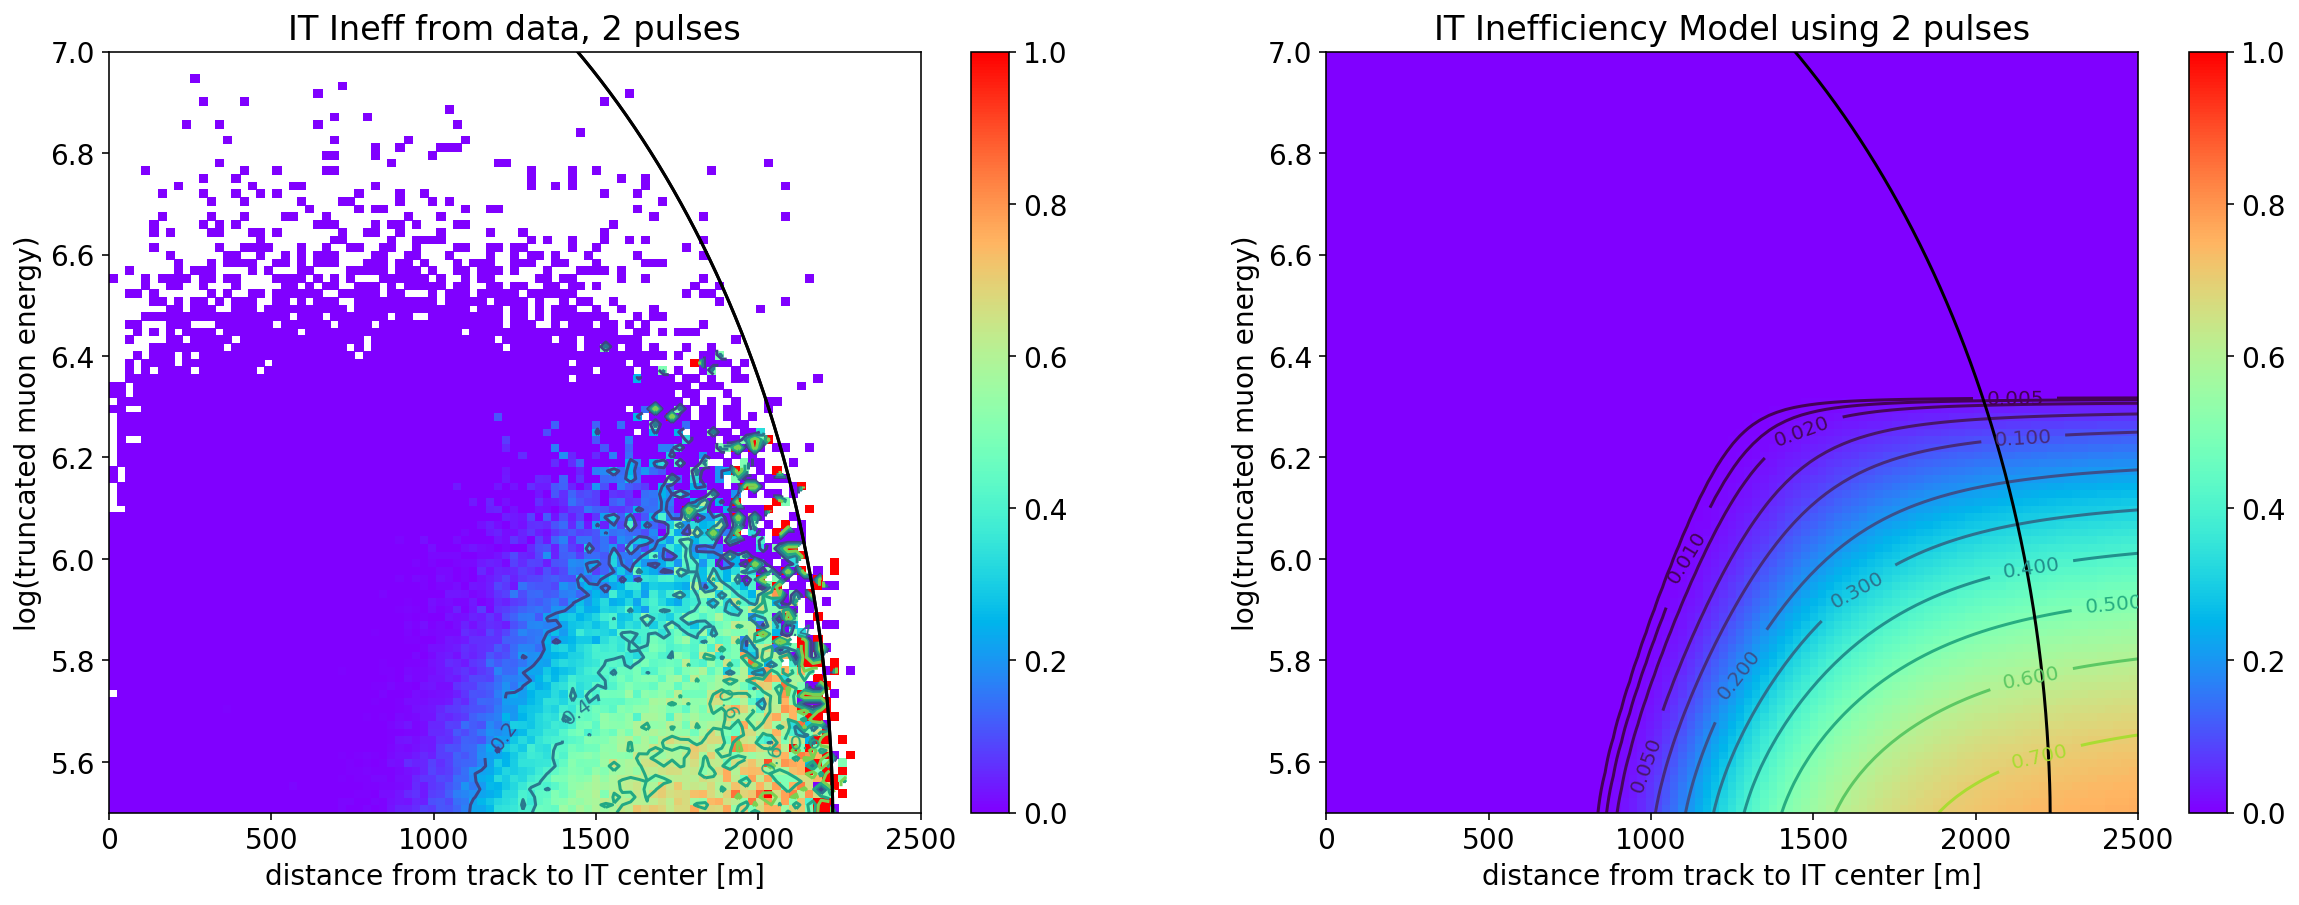

In [22]:
ineff_baseline,cs_baseline = modeling(0.0)

In [26]:
def show_contour(L):
    levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

    level_07 = cs_07.allsegs[L][0]
    level_10 = cs_10.allsegs[L][0]
    level_13 = cs_13.allsegs[L][0]
    level_baseline = cs_baseline.allsegs[L][0]

    plt.figure(figsize=(7,5))
    cmap = matplotlib.cm.get_cmap('rainbow_r')
    plt.plot(level_07[:,0],level_07[:,1],label='7% shift',color=cmap(0.0))
    plt.plot(level_10[:,0],level_10[:,1],label='10% shift',color=cmap(0.2))
    plt.plot(level_13[:,0],level_13[:,1],label='13% shift',color=cmap(0.4))
    plt.plot(level_baseline[:,0],level_baseline[:,1],'--',label='baseline',color='black')

    plt.title('contour: ineff = '+str(levels[L]))    
    plt.xlabel('distance from track to IT center [m]')
    plt.ylabel('log(truncated muon energy)')
    plt.xlim(0,2500)
    plt.ylim(5.5,7)
    plt.legend()
    plt.show()

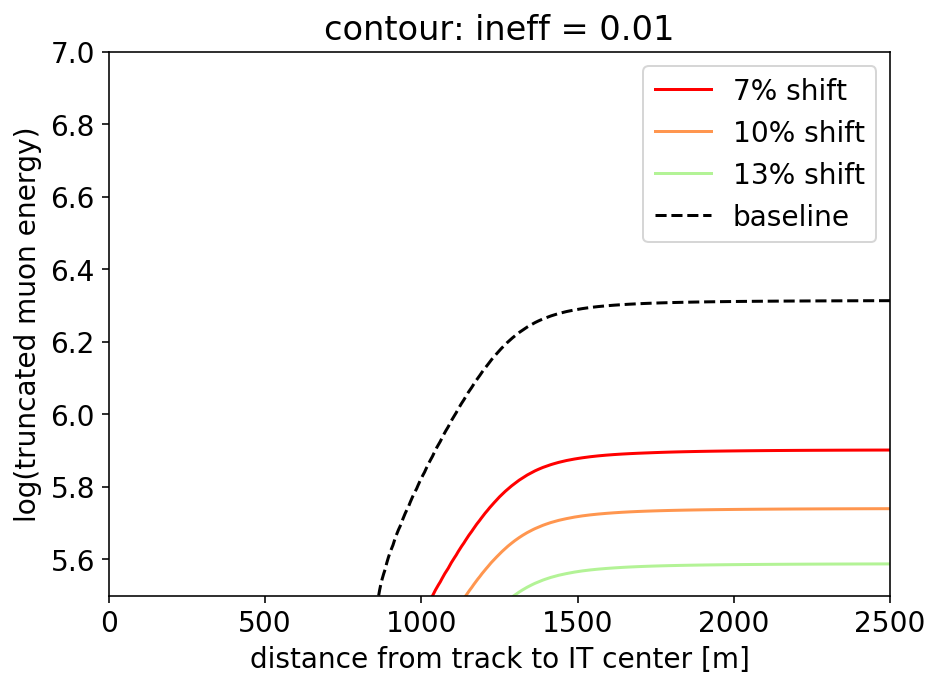

In [27]:
show_contour(1)

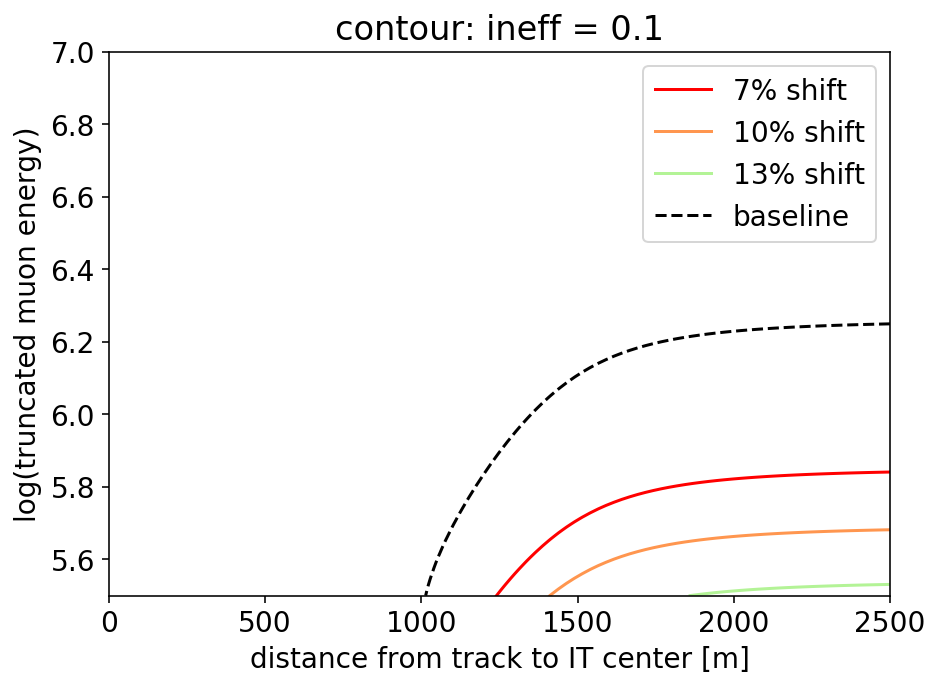

In [29]:
show_contour(4)